<a href="https://colab.research.google.com/github/IoannisPan11/Breast_Tumor_Segmentation/blob/main/breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "./drive/My Drive/DIPLOMATIKH/panagiotopoulos_thesis/code/"

In [ ]:
%%capture
!pip install pydicom
!pip3 install git+https://github.com/itzortzis/INBreast_XML_parser.git

In [ ]:
%pwd

In [ ]:
#import anot_core as anot
from anot_core import annotation as anot

import os
import cv2
import csv
import sys
import argparse
import numpy as np
import pydicom as pdcm
from matplotlib import pyplot as plt
import torch
import PIL
import torchvision.transforms as T
import skimage.exposure as skie
%matplotlib inline
from skimage.util.dtype import img_as_bool
from skimage.transform import rotate
from skimage.exposure import equalize_hist
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.exposure import adjust_gamma
from tqdm import tqdm
import matplotlib.patches as patches
import torchvision.transforms as transforms

In [ ]:
paths = {
    'xml': './INBreast/XML/',
    'dcm': './INBreast/DICOM/',
    'csv': './INBreast/INbreast_compact.csv'
}

args = {
    'p_size': 512,
    'p_step': 50,
    'ppi': 6, # Maximum patchesper image
    'h_ppi': 6
}

# Dataset list creation

In [ ]:
def build_dcm_dict(path_to_csv):
  dcm_list = []

  with open(path_to_csv) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    dict_key   = 0

    for row in csv_reader:
      if line_count == 0:
        line_count += 1
        continue
      obj = {"filename": row[5],
              "mass": row[8],
              "calc": row[9]}
      dcm_list.append(obj)
      line_count += 1
      dict_key += 1
    print(f'Processed {line_count} lines.')

  return dcm_list

obj_list = build_dcm_dict(paths['csv'])

# Visualization of the dataset


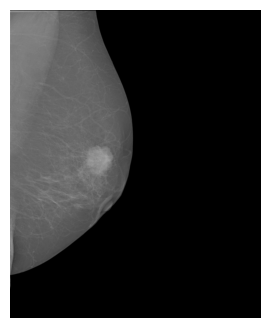

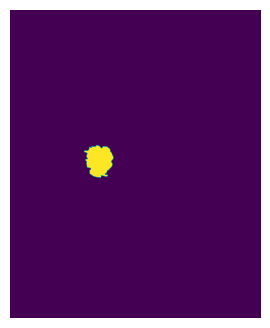

In [ ]:
def create_fig(img_name):

  path_to_dcm = paths['dcm'] + img_name + '.dcm'
  print(path_to_dcm)
  img_obj = pdcm.dcmread(path_to_dcm)
  img = img_obj.pixel_array

  mask_obj = anot.Annotation(paths['xml'], img_name, img.shape)
  mask = mask_obj.mask

  plt.figure(figsize=(10, 4))
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.show()
  plt.figure(figsize=(10, 4))
  plt.imshow(mask_obj.mask[:, :, 0])
  plt.axis('off')
  plt.show()


create_fig(obj_list[146]['filename'])

# Preprocessing and Augmentation

In [ ]:
def crop(img):

  l = 0
  r = img.shape[1] - 1
  t = 0
  b = img.shape[0] - 1

  while np.sum(img[:, l]) == 0: l += 1
  while np.sum(img[:, r]) == 0: r -= 1
  while np.sum(img[t, :]) == 0: t += 1
  while np.sum(img[b, :]) == 0: b -= 1

  return img[t:b, l:r], l, r, t, b


def resize_img(img, mask, dim):

  resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  resized_mask = cv2.resize(mask, dim, interpolation=cv2.INTER_AREA)

  return resized_img, resized_mask


def load_img_mask(img_name):

  path_to_dcm = paths['dcm'] + img_name + '.dcm'
  img_obj = pdcm.dcmread(path_to_dcm)
  img = img_obj.pixel_array

  mask_obj = anot.Annotation(paths['xml'], img_name, img.shape)
  mask = mask_obj.mask

  return img, mask[:, :, 0]


def show_img(img):

  plt.figure()
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.show()


def augment_img_1(img):

  output = equalize_hist(img)

  return output


def augment_img_2(img):

  output = adjust_gamma(img,gamma=0.5,gain=1)

  return output


def augment_img_3(img):

  output = rotate(img, angle=180, resize=True)

  return output


def initialize_dataset(obj_list):

  dataset = np.zeros((len(obj_list), 256, 256, 2))

  for i in tqdm(range(len(obj_list))):

    img_name = obj_list[i]['filename']
    img, mask = load_img_mask(img_name)

    or_img = img
    img = (img - img.min()) / (img.max() - img.min())
    img *= 255
    img = np.uint8(img)

    c_img, l, r, t, b = crop(img)
    c_mask = mask[t:b, l:r]
    r_img, r_mask = resize_img(c_img, c_mask, (256, 256))

    dataset[i, :, :, 0] = r_img
    dataset[i, :, :, 1] = r_mask

  return dataset


def augmentation_1(dataset):

  aug_dataset_1 = np.zeros((len(obj_list), 256, 256, 2))

  for i in tqdm(range(len(obj_list))):
    aug_img = augment_img_1(dataset[i, :, :, 0])
    aug_dataset_1[i, :, :, 0] = aug_img
    aug_dataset_1[i, :, :, 1] = dataset[i, :, :, 1]

  return aug_dataset_1


def augmentation_2(dataset):

  aug_dataset_2 = np.zeros((len(obj_list), 256, 256, 2))

  for i in tqdm(range(len(obj_list))):
    aug_img = augment_img_2(dataset[i, :, :, 0])
    aug_dataset_2[i, :, :, 0] = aug_img
    aug_dataset_2[i, :, :, 1] = dataset[i, :, :, 1]

  return aug_dataset_2

def augmentation_3(temp_dataset_2):

  aug_dataset_3 = np.zeros((3*len(obj_list), 256, 256, 2))

  for i in tqdm(range(3*len(obj_list))):
    aug_img = augment_img_3(temp_dataset_2[i, :, :, 0])
    aug_mask = augment_img_3(temp_dataset_2[i, :, :, 1])
    aug_dataset_3[i, :, :, 0] = aug_img
    aug_dataset_3[i, :, :, 1] = aug_mask

  return aug_dataset_3

In [ ]:
dataset = initialize_dataset(obj_list)

  7%|▋         | 29/410 [00:32<06:27,  1.02s/it]

./INBreast/XML/22670620.xml


 73%|███████▎  | 299/410 [05:23<02:00,  1.09s/it]

./INBreast/XML/22670094.xml


 82%|████████▏ | 335/410 [06:06<01:44,  1.39s/it]

./INBreast/XML/53587663.xml


100%|██████████| 410/410 [07:24<00:00,  1.08s/it]


# Normalization

In [ ]:
dataset[:, :, :, 0] = (dataset[:, :, :, 0] - np.min(dataset[:, :, :, 0])) / (np.max(dataset[:, :, :, 0]) - np.min(dataset[:, :, :, 0]))

In [ ]:
aug_dataset_1 = augmentation_1(dataset)

temp_dataset_1 = np.zeros((len(dataset)+len(aug_dataset_1), 256, 256, 2))
temp_dataset_1[:len(dataset), :, :, :] = dataset
temp_dataset_1[len(dataset):, :, :, :] = aug_dataset_1

aug_dataset_2 = augmentation_2(dataset)

temp_dataset_2 = np.zeros((len(temp_dataset_1)+len(aug_dataset_2), 256, 256, 2))
temp_dataset_2[:len(temp_dataset_1), :, :, :] = temp_dataset_1
temp_dataset_2[len(temp_dataset_1):, :, :, :] = aug_dataset_2

aug_dataset_3 = augmentation_3(temp_dataset_2)

final_dataset = np.zeros((len(temp_dataset_2)+len(aug_dataset_3), 256, 256, 2))
final_dataset[:len(temp_dataset_2), :, :, :] = temp_dataset_2
final_dataset[len(temp_dataset_2):, :, :, :] = aug_dataset_3

100%|██████████| 1230/1230 [00:06<00:00, 201.88it/s]


# Split final dataset to training, validation and testing set

In [ ]:
final_dataset = dataset

In [ ]:
rp = np.random.permutation(final_dataset.shape[0])
p_dataset = final_dataset[rp]
print(p_dataset.shape)

(2460, 256, 256, 2)


In [ ]:
training_set_size = int(0.7 * (len(p_dataset)))
validation_set_size = int(0.2 * (len(p_dataset)))
testing_set_size = int(0.1 * (len(p_dataset)))

train_start = 0
train_end = training_set_size
valid_start = train_end
valid_end = valid_start + validation_set_size
test_start = valid_end
test_end = test_start + testing_set_size

training_set = p_dataset[train_start:train_end, :, :, :]
validation_set = p_dataset[valid_start: valid_end, :, :, :]
testing_set = p_dataset[test_start: test_end, :, :, :]

print("Training set: ", training_set.shape)
print("Validation set: ", validation_set.shape)
print("Testing set: ", testing_set.shape)

Training set:  (1722, 256, 256, 2)
Validation set:  (492, 256, 256, 2)
Testing set:  (246, 256, 256, 2)


# Loaders

In [ ]:
import torch

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dataset):
        self.dataset = dataset

  def __len__(self):
        return len(self.dataset)

  def __getitem__(self, index):
        x = self.dataset[index, :, :, 0]
        y = self.dataset[index, :, :, 1]

        x = torch.from_numpy(x)
        y = torch.from_numpy(y)

        return x, y


train = Dataset(training_set)
params = {'batch_size': 7, 'shuffle': True}
training_generator = torch.utils.data.DataLoader(train, **params)
print("Number of batches (training): ", len(training_generator))

valid = Dataset(validation_set)
params = {'batch_size': 7, 'shuffle': False}
validation_generator = torch.utils.data.DataLoader(valid, **params)
print("Number of batches (validation): ", len(validation_generator))

test = Dataset(testing_set)
params = {'batch_size': 7, 'shuffle': False}
testing_generator = torch.utils.data.DataLoader(test, **params)
print("Number of batches (testing): ", len(testing_generator))

Number of batches (training):  246
Number of batches (validation):  71
Number of batches (testing):  36


# The UNET model

In [ ]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        return expand

# Metrics

In [ ]:
%%capture
!pip install torchmetrics
from torchmetrics import Dice

In [ ]:
def calculate_dice(preds, targets):
		preds = preds.cpu()
		targets = targets.cpu()
		preds = torch.argmax(preds, dim=1)
		preds = preds.view(-1)
		targets = targets.view(-1)
		dice = Dice(average='macro', num_classes=2)
		d = dice(preds, targets)
		return d

# Training Loop

In [ ]:
import numpy as np

max_epochs = 50
in_channels = 1
out_channels = 2

unet = UNET(in_channels, out_channels)
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.001)

training_f1 = np.zeros((max_epochs, 1))
training_loss = np.zeros((max_epochs, 1))
validation_f1 = np.zeros((max_epochs, 1))
validation_loss = np.zeros((max_epochs, 1))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
unet = unet.to(device)

print("Number of batches (training): ", len(training_generator))
print("Number of batches (validation): ", len(validation_generator))

'''Training'''
for epoch in tqdm(range(max_epochs)):
  print()
  f1_sum = 0

  for x, y in training_generator:
    x = torch.unsqueeze(x, 1)
    x = x.to(torch.float32)
    y = y.to(torch.int64)

    x = x.to(device)
    y = y.to(device)

    opt.zero_grad()
    predictions = unet(x)
    loss = loss_fn(predictions, y)
    loss.backward()
    opt.step()

    f1 = calculate_dice(predictions, y)
    f1 = f1.item()
    f1_sum += f1

  batch_mean_f1 = f1_sum/len(training_generator)
  training_f1[epoch] = batch_mean_f1
  training_loss[epoch] = loss.item()
  print("Batch mean of f1 (training): {:.6f}".format(float(training_f1[epoch])))


  '''Validation'''
  f1_sum = 0
  for x, y in validation_generator:
    x = torch.unsqueeze(x, 1)
    x = x.to(torch.float32)
    y = y.to(torch.int64)

    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
      outputs = unet(x)
      loss = loss_fn(outputs, y)

      f1 = calculate_dice(outputs, y)
      f1 = f1.item()
      f1_sum += f1

  batch_mean_f1 = f1_sum / len(validation_generator)
  validation_f1[epoch] = batch_mean_f1
  validation_loss[epoch] = loss.item()
  print()
  print("Batch mean of f1 (validation): {:.6f}".format(float(validation_f1[epoch])))

In [ ]:
print("Number of batches (testing): ", len(testing_generator))

f1_sum = 0
for x, y in testing_generator:
  x = torch.unsqueeze(x, 1)
  x = x.to(torch.float32)
  y = y.to(torch.int64)

  x = x.to(device)
  y = y.to(device)

  with torch.no_grad():
    outputs = unet(x)

    loss = loss_fn(outputs, y)

    f1 = calculate_dice(outputs, y)
    f1 = f1.item()
    f1_sum += f1

batch_mean_f1 = f1_sum / len(testing_generator)
testing_f1 = batch_mean_f1
print("Batch mean of f1 (testing): {:.6f}".format(float(testing_f1)))
test_f1 = np.zeros((1))
test_f1[0] = testing_f1

Number of batches (testing):  36
Batch mean of f1 (testing): 0.637806


In [ ]:
print(training_f1.shape)
print(test_f1)

(50, 1)
[0.63780632]


In [ ]:
import numpy as np
import time
import calendar
current_GMT = time.gmtime()
timestamp = calendar.timegm(current_GMT)
print(timestamp)
exp = 'epochs50_FinalDataset_slr'
np.save(exp + '/Training_f1_' + str(timestamp),training_f1)
np.save(exp +'/Validation_f1_' + str(timestamp),validation_f1)
np.save(exp +'/Training_loss_' + str(timestamp),training_loss)
np.save(exp +'/Validation_loss_' + str(timestamp),validation_loss)
np.save(exp +'/Testing_f1_' + str(timestamp),test_f1)

1699756592
